In [1]:
import os
import ast
import random
import logging
import numpy as np
import pandas as pd

from tqdm import tqdm_notebook as tqdm
from collections import OrderedDict

import sys
sys.path.append('..')

In [2]:
class OmniscienceReader(object):
    """
    docstring for OmniscienceReader
    [x] preprocess raw text: gensim preprocesser : stop words + stemming + lemma + tokenize + -num
    [x] raw text -> word2vec using fasttext
    [x] avg word2vec across docs to create doc2vec
    [x] distirbution of classes per document
    """
    def __init__(self, file_path):
        super(OmniscienceReader, self).__init__()
        self.file_path = file_path
        self.preprocess()

    def preprocess(self):
        self.om_df = pd.read_csv(self.file_path, sep='\t', encoding='utf-8')
        self.om_df = self.om_df.dropna()

        self.om_df["omniscience_label_ids"] = self.om_df["omniscience_label_ids"].apply(lambda x: ast.literal_eval(x) )
        self.om_df["omniscience_labels"] = self.om_df["omniscience_labels"].apply(lambda x: ast.literal_eval(x) )
        
        self.om_df["omniscience_label_ids"] = self.om_df["omniscience_label_ids"].apply(lambda x: list(set(x)))
        self.om_df["omniscience_labels"] = self.om_df["omniscience_labels"].apply(lambda x: list(set(x)))
        
        self.om_df["category"] = self.om_df["file_id"].apply(lambda x: x.split(":")[0])
        self.om_df["doc_id"] = 0

        for i in tqdm(self.om_df.index):
            self.om_df.at[i, "doc_id"] = i
            if self.om_df.at[i, "category"] == "EVISE.PII":
                self.om_df.at[i, "omniscience_label_ids"] = list(map(int, self.om_df.at[i, "omniscience_label_ids"][0]))

        return self.om_df

In [3]:
O = OmniscienceReader("../OmniScience/original/ArXiv_BMED_Evise_title_abstract_os.2018-07-11.tsv")

In [42]:
groups = O.om_df.groupby("used_as")

In [53]:
training = groups.get_group("training")
validation = groups.get_group("validation")
testing = groups.get_group("unused")

In [ ]:
# split dfs first. then send each df to a function where it can preprocess and save tr/te/vl as sep files

In [7]:
def oms_replacer(data):
    return data.lower().replace(".", " . ").replace("(", " ( ").replace(",", " ,").replace(")", " ) ")

In [81]:
def oms_converter(df, main_path, split_name):
    
    fe, ex = os.path.splitext(main_path)
    
    save_file_as = "{}-oms-{}_fasttext.txt".format(fe, split_name)
    
    new_df = pd.DataFrame(columns=["label", "document"])
    new_df["document"] = df["title"] + " : " + df["abstract"]
    new_df["document"] = new_df["document"].apply(lambda x: oms_replacer(x))
    new_df["label"] = df["omniscience_labels"]
        
    temp_dict = new_df.to_dict(orient='list')
    temp = list(temp_dict.values())
    
    all_labels = temp[0]
    all_content = temp[1]
    label = []
    content = []

    print("--Beginning to convert to fasttext format--")
    for i in range(len(all_labels)):
        if len(all_labels[i]) > 1:
            for j in all_labels[i]:
                label.append(j.replace("_", "-"))
                content.append(all_content[i])
        else:
            label.append(all_labels[i][0].replace("_", "-"))
            content.append(all_content[i])
            
    # regular saving
    wmain = open(save_file_as, "wb+")
    for i in range(len(label)):
        line = "__label__{} , {}\n".format(label[i], content[i])
        wmain.write(line.encode("utf-8"))
    wmain.close()
    
    # shuffling
    lines = open(save_file_as, 'rb').readlines()
    random.shuffle(lines)
    open(save_file_as, 'wb').writelines(lines)
    
    print("--Finished converting to fasttext--")

In [82]:
oms_converter(testing, "test")

--Beginning to convert to fasttext format--
--Finished converting to fasttext--


In [10]:
new_df["label"].apply(lambda x: len(x)).sum()

36

In [17]:
len(label)

36

In [22]:
def swiki_replacer(lines):

    lines = lines.replace("<DOC>", "")
    lines = lines.replace("</DOC>", "")
    lines = lines.replace("<DOCNO>", "")
    lines = lines.replace("</DOCNO>", "")
    lines = lines.replace("<LABELS>", "OMGTHISSHOULDBEARAREWORD")
    lines = lines.replace("</LABELS>", "")
    
    lines = lines.replace(".", " . ")
    lines = lines.replace("?", " ? ")
    lines = lines.replace("!", " ! ")
    lines = lines.replace(")", " ) ")
    lines = lines.replace("(", " ( ")
    
    return lines

In [3]:
def clean_up(filename):
    
    fe, ex = os.path.splitext(filename)
    new_f = "{}_fasttext{}".format(fe, ex)
    
    with open(filename, "r") as fmain:
        reader = fmain.readlines()
        
    wmain = open(new_f, "w+")
    for i, lines in enumerate(tqdm(reader)):
        one = lines.replace("  ", " ").replace("\n", "")
        if len(lines) > 2:
            umm_split = one.split(",")
            labs = umm_split[0]
            therest = umm_split[1:]
            str_wut = ''.join(therest)
            wmain.write("{} ,{} \n".format(labs, str_wut))
    wmain.close()
    
    os.remove(filename)
    
    return new_f

In [74]:
def shuffle_lines(filename):
    
    lines = open(filename).readlines()
    random.shuffle(lines)
    open(filename, 'w').writelines(lines)

In [5]:
def swiki_converter(filename):
    
    print("--Beginning conversion for swiki--")
    
    fe, ex = os.path.splitext(filename)
    new_f = "{}_level1{}".format(fe, ex)
    
    with open(filename, "r") as fmain:
        reader = fmain.readlines()
    
    labels = []
    content = []
    long_labels = []

    for i, lines in enumerate(tqdm(reader)):

        fmt = swiki_replacer(lines)

        if "OMGTHISSHOULDBEARAREWORD" in fmt:
            fmt = fmt.strip().replace("OMGTHISSHOULDBEARAREWORD", "")
            fmt = fmt.split(' ')
            labels.append(fmt)

        if len(fmt) > 50:
            fmt = fmt.lower()
            if len(labels[-1]) > 0:
                for k in labels[-1]:
                    long_labels.append(k)
                    content.append(fmt)                    
    del labels
    
    g = pd.DataFrame(columns = ["label", "doc"])
    g["label"] = long_labels    
    g["doc"] = content    
    g["label"] = g["label"].apply(lambda x: "__label__{}".format(x))    
    g.to_csv(new_f, header=False, index=False, sep=',', quotechar=' ')
    
    new_file = clean_up(new_f)
    print("--Finished converting swiki to fasttext format--")
    
    print("--Shuffling lines in the file--")
    shuffle_lines(new_file)
    print("--Finished shuffling lines--")

In [6]:
swiki_converter("../raw-swiki/train/swiki-train.txt")

--Beginning conversion for swiki--



--Finished converting swiki to fasttext format--
--Shuffling lines in the file--
--Finished shuffling lines--


In [23]:
import networkx as nx

In [24]:
b = [(0, 1), (0, 2), (1, 3), (2, 3)]

In [25]:
G = nx.DiGraph()

In [26]:
G.add_edges_from(b)

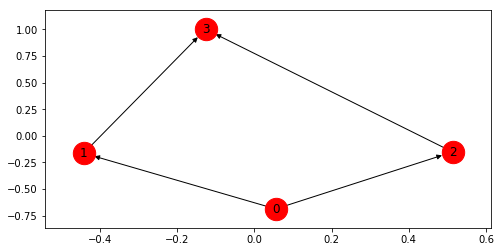

In [39]:
plt.figure(figsize=(8,4))
nx.draw_networkx(G, with_labels=True, node_size=500)

In [27]:
def BFS(s): 
    # applicable only for directed graphs
    visited = [0] * (len(G)) 
    traversal = []
    new_edges = []
    queue = [] 

    queue.append(s) 
    visited[s]+=1

    while queue: 

        s = queue.pop(0) 
        traversal.append(s)

        for i in G.neighbors(s): 
            queue.append(i) 
            visited[i] +=1
            if visited[i] != 1:
#                 new_edges.append((s, i+visited[i]+len(G)))
                new_edges.append((s, "{}-{}".format(s, i)))
            else:
                new_edges.append((s, i))
            
    return new_edges

In [28]:
new_edges = BFS(0)

In [29]:
r = nx.DiGraph()

In [30]:
r.add_edges_from(new_edges)

In [31]:
r.edges()

OutEdgeView([(0, 1), (0, 2), (1, 3), (2, '2-3')])

In [32]:
nx.is_tree(r)

True

In [34]:
import matplotlib.pyplot as plt

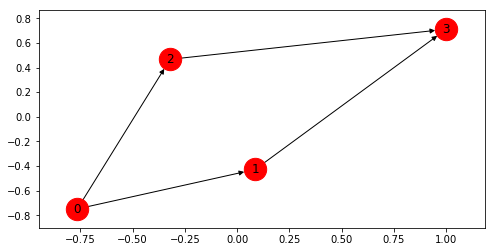

In [38]:
plt.figure(figsize=(8,4))
nx.draw_networkx(G, with_labels=True, node_size=500)